In [1]:
%pip install datasets nltk
%pip install torchtext==0.17.0
%pip install -U portalocker>=2.0.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 18.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system =

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import nltk
nltk.download('punkt')

device = 'cuda' if torch.cuda.is_available() else 'cpu'


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.11/dist-package

**Data Preparation**

In [3]:
from datasets import load_dataset

imdb = load_dataset("imdb")
train_data, test_data = imdb["train"], imdb["test"]

README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [4]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

tokenizer = get_tokenizer("basic_english")
vocab_size = 20000

def yield_tokens(data_iter):
  for data in data_iter:
    yield tokenizer(data["text"])

vocab = build_vocab_from_iterator(yield_tokens(train_data),
                                  min_freq=3,
                                  max_tokens=vocab_size,
                                  specials=["<pad>", "<s>", "<unk>"])
vocab.set_default_index(vocab["<unk>"])

In [13]:
seq_length = 200
text_pipeline = lambda x: vocab(tokenizer(x))

def collate_batch(batch, seq_length=seq_length):
    text_list, label_list = [], []
    for sample in batch:
        label_list.append(sample['label'])

        text_processed = text_pipeline(sample['text'])[:seq_length]
        if len(text_processed) < seq_length:
            pad_size = seq_length - len(text_processed) -1
            text_processed = [vocab["<pad>"]] * pad_size + [vocab["<s>"]] + text_processed
        text_list.append(text_processed)

    input_ids = torch.tensor(text_list, dtype=torch.int64)
    labels = torch.tensor(label_list, dtype=torch.int64)
    return (input_ids, labels)

In [14]:
from torch.utils.data import DataLoader
batch_size = 32

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=collate_batch, drop_last=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=collate_batch, drop_last=True)

**Model**

In [15]:
class MyMultiheadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(MyMultiheadAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        assert self.head_dim * num_heads == self.embed_dim, "embed_dim must be divisible by num_heads"

        self.query_linear = nn.Linear(embed_dim, embed_dim)
        self.key_linear = nn.Linear(embed_dim, embed_dim)
        self.value_linear = nn.Linear(embed_dim, embed_dim)
        self.out_linear = nn.Linear(embed_dim, embed_dim)

    def forward(self, query, key, value):
        batch_size = query.size(0)

        # Linear projections
        query = self.query_linear(query)
        key = self.key_linear(key)
        value = self.value_linear(value)

        # Reshape for multi-head attention
        query = query.view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        key = key.view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        value = value.view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)

        # Scaled dot-product attention
        scores = torch.matmul(query, key.transpose(-2, -1)) / (self.head_dim ** 0.5)

        attention_weights = F.softmax(scores, dim=-1)
        context = torch.matmul(attention_weights, value)

        # Concatenate heads and apply final linear layer
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.embed_dim)
        output = self.out_linear(context)

        return output, attention_weights

class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout):
        super().__init__()
        self.attn = MyMultiheadAttention(embed_dim=embed_dim, num_heads=num_heads)

        self.layernorm = nn.LayerNorm(normalized_shape=embed_dim, eps=1e-6)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, query, key, value):
        attn_output, _ = self.attn(query, key, value)
        attn_output = self.dropout(attn_output)
        output = self.layernorm(query + attn_output)
        return output


class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size, embed_dim, max_length, device):
        super().__init__()
        self.device = device
        self.word_emb = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embed_dim)

    def forward(self, x):
        output = self.word_emb(x)
        return output


class TransformerTextCls(nn.Module):
    def __init__(self, vocab_size, max_length, embed_dim, num_heads, dropout, device):
        super().__init__()
        self.embd_layer = TokenEmbedding(vocab_size, embed_dim, max_length, device)
        self.transformer_layer = TransformerBlock(embed_dim, num_heads, dropout)

        self.fc = nn.Linear(in_features=200*32, out_features=2)
    def forward(self, x):
        output = self.embd_layer(x)
        output = self.transformer_layer(output, output, output)
        output = nn.Flatten()(output)
        output = self.fc(output)
        return output


In [16]:
max_length = seq_length #200
embed_dim = 32
num_heads = 2
ff_dim = 32
dropout = 0.1
model = TransformerTextCls(vocab_size, max_length, embed_dim, num_heads, dropout, device)

In [17]:
import torch
x = torch.randint(0, vocab_size, (batch_size, seq_length))
output = model(x)
output.shape

torch.Size([32, 2])

**Evaluate**

In [19]:
def evaluate(model, test_loader, criterion, device):
  model.eval()
  test_loss = 0.0
  correct = 0
  total=0
  with torch.no_grad():
    for inputs, labels in test_loader:
      inputs, labels = inputs.to(device), labels.to(device)

      outputs = model(inputs)
      loss = criterion(outputs, labels)
      _, predicted = torch.max(outputs, 1)

      total += labels.size(0)
      test_loss += loss.item()
      correct += (predicted == labels).sum().item()

  test_loss = loss / len(test_loader)
  accuracy = 100 * correct / total

  return test_loss, accuracy

# Train

In [20]:
max_epoch = 20
lr = 0.001
criterion = nn. CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

model.to(device)
for epoch in range(max_epoch):
  model.train()
  running_loss = 0.0
  running_correct = 0
  total = 0
  for inputs, labels in train_loader:
    inputs , labels = inputs.to(device), labels.to(device)

    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    running_loss += loss.item()

    _, predicted = torch.max(outputs, 1)
    total += labels.size(0)
    running_correct += (predicted == labels).sum().item()

    loss.backward()
    optimizer.step()

  epoch_loss = loss / len(train_loader)
  epoch_accuracy = 100 * running_correct / total
  test_loss, test_accuracy = evaluate(model, test_loader, criterion, device)

  print(f"Epoch [{epoch + 1}/{max_epoch}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

  train_losses.append(epoch_loss)
  train_accuracies.append(epoch_accuracy)
  test_losses.append(test_loss)
  test_accuracies.append(test_accuracy)


Epoch [1/20], Loss: 0.0006, Accuracy: 60.40%, Test Loss: 0.0019, Test Accuracy: 64.13%
Epoch [2/20], Loss: 0.0006, Accuracy: 78.72%, Test Loss: 0.0006, Test Accuracy: 74.06%
Epoch [3/20], Loss: 0.0004, Accuracy: 85.70%, Test Loss: 0.0007, Test Accuracy: 76.97%
Epoch [4/20], Loss: 0.0004, Accuracy: 89.94%, Test Loss: 0.0012, Test Accuracy: 76.69%
Epoch [5/20], Loss: 0.0005, Accuracy: 93.42%, Test Loss: 0.0010, Test Accuracy: 78.88%
Epoch [6/20], Loss: 0.0002, Accuracy: 95.91%, Test Loss: 0.0009, Test Accuracy: 78.26%
Epoch [7/20], Loss: 0.0001, Accuracy: 97.88%, Test Loss: 0.0011, Test Accuracy: 78.44%
Epoch [8/20], Loss: 0.0001, Accuracy: 99.10%, Test Loss: 0.0014, Test Accuracy: 78.55%
Epoch [9/20], Loss: 0.0001, Accuracy: 99.46%, Test Loss: 0.0019, Test Accuracy: 78.59%
Epoch [10/20], Loss: 0.0001, Accuracy: 99.77%, Test Loss: 0.0019, Test Accuracy: 78.84%
Epoch [11/20], Loss: 0.0000, Accuracy: 99.52%, Test Loss: 0.0020, Test Accuracy: 79.33%
Epoch [12/20], Loss: 0.0000, Accuracy: 99

In [22]:
!pip install numpy
import numpy as np

RuntimeError: Numpy is not available

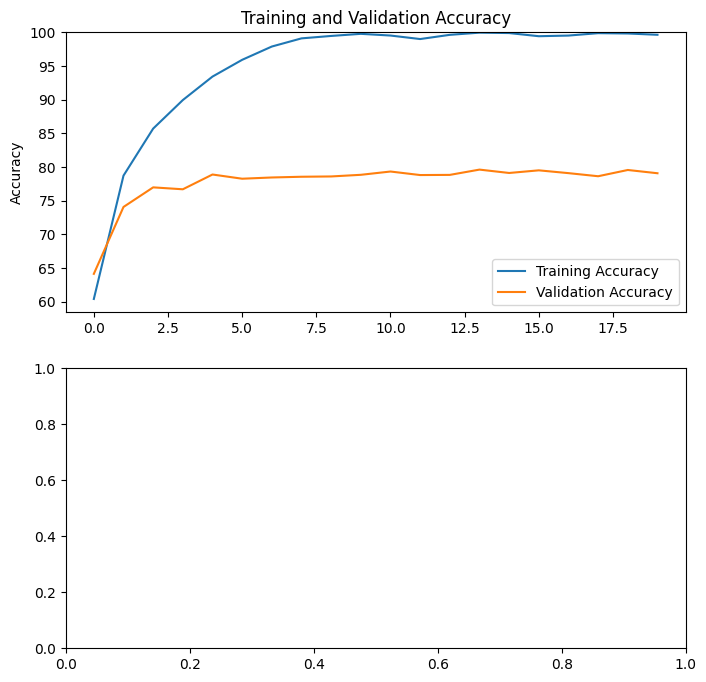

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(test_accuracies, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),100])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Binary Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()